## Data Visualization in BlazingSQL Notebooks

In [1]:
from blazingsql import BlazingContext

# connect to BlazingSQL w/ BlazingContext API
bc = BlazingContext()

BlazingContext ready


In [2]:
import os

# identify path to data directory
data_dir = os.getcwd().replace('/intro_notebooks', '/data')

# create a BlazingSQL table from any file w/ .create_table(table_name, file_path)
bc.create_table('taxi', f'{data_dir}/sample_taxi.csv', header=0)

In [3]:
# what's the data look like?
bc.sql('select * from taxi limit 7')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_x,pickup_y,dropoff_x,dropoff_y
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,1,N,1,12.0,1.0,0.5,3.25,0.00,0.3,17.05,-8236962.878,66.693057,-8234835.381,66.694056
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,1,N,1,14.5,0.5,0.5,2.00,0.00,0.3,17.80,-8237825.768,66.642117,-8237020.631,66.710783
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,1,N,2,9.5,0.5,0.5,0.00,0.00,0.3,10.80,-8233561.431,66.796854,-8232278.987,66.839490
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,1,N,2,3.5,0.5,0.5,0.00,0.00,0.3,4.80,-8238653.836,66.621592,-8238123.872,66.633735
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,1,N,2,15.0,0.5,0.5,0.00,0.00,0.3,16.30,-8234433.662,66.717321,-8238107.735,66.678369
5,1,2015-01-10 20:33:39,2015-01-10 20:53:52,1,9.00,1,N,1,27.0,0.5,0.5,6.70,5.33,0.3,40.33,-8223657.740,66.740214,-8236192.563,66.708979
6,1,2015-01-10 20:33:39,2015-01-10 20:58:31,1,2.20,1,N,2,14.0,0.5,0.5,0.00,0.00,0.3,15.30,-8235780.653,66.645594,-8236804.060,66.692118


### Matplotlib 

[GitHub](https://github.com/matplotlib/matplotlib)

Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.

By calling the `.to_pandas()` method, we can convert a `cudf.DataFrame` into a `pandas.DataFrame` and hand off to Matplotlib or other CPU visualization packages.

In [4]:
# convert query results to pandas and save DataFrame as variable 
df = bc.sql('SELECT * FROM taxi').to_pandas()

# identify feature correlations 
corr = df.corr()

# colorize & plot out feature correlations 
corr.style.background_gradient(cmap='coolwarm')

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_x,pickup_y,dropoff_x,dropoff_y
VendorID,1,0.299742,-0.00132903,-0.00977762,-0.0112657,0.00175996,0.00988121,0.00692277,-0.0117453,0.00217687,0.242798,-0.000436702,0.00796707,0.00762232,0.00216507,0.00615316
passenger_count,0.299742,1,-0.000553125,-0.00516744,0.0131011,0.00738508,0.00684952,0.00529868,-0.0111071,0.00391433,0.0458663,0.00436833,-0.00211478,-0.00232565,-0.00121632,-0.000283777
trip_distance,-0.00132903,-0.000553125,1,0.00102591,-0.000698798,0.0159808,-0.000333643,5.56622e-05,0.00871679,0.00981547,0.000102859,0.0159401,0.00517996,-0.000454872,0.00744814,0.00167076
RatecodeID,-0.00977762,-0.00516744,0.00102591,1,-0.000590712,0.062974,-0.0124544,-0.190843,0.0269015,0.045547,-0.00414398,0.060851,0.00446507,-0.00245536,-0.00789674,-0.00132013
payment_type,-0.0112657,0.0131011,-0.000698798,-0.000590712,1,-0.0961275,-0.0313527,-0.0458749,-0.595002,-0.0458035,-0.0463016,-0.212781,0.0344114,0.0653233,0.0439404,0.0649564
fare_amount,0.00175996,0.00738508,0.0159808,0.062974,-0.0961275,1,-0.00585413,-0.0816051,0.501594,0.480711,0.00168625,0.973958,0.234968,-0.0282738,0.280641,-0.0507077
extra,0.00988121,0.00684952,-0.000333643,-0.0124544,-0.0313527,-0.00585413,1,0.0406312,0.0334733,-0.0206284,0.0345444,0.0443768,-0.0319038,-0.0525884,0.021845,-0.0223311
mta_tax,0.00692277,0.00529868,5.56622e-05,-0.190843,-0.0458749,-0.0816051,0.0406312,1,-0.0300559,-0.0757462,0.00586908,-0.0754526,-0.00242349,0.00384593,0.0166294,0.00271048
tip_amount,-0.0117453,-0.0111071,0.00871679,0.0269015,-0.595002,0.501594,0.0334733,-0.0300559,1,0.353614,0.0264519,0.663295,0.139598,-0.0377305,0.122896,-0.0584887
tolls_amount,0.00217687,0.00391433,0.00981547,0.045547,-0.0458035,0.480711,-0.0206284,-0.0757462,0.353614,1,0.00263769,0.574899,0.363445,0.0679587,0.247424,0.0393681


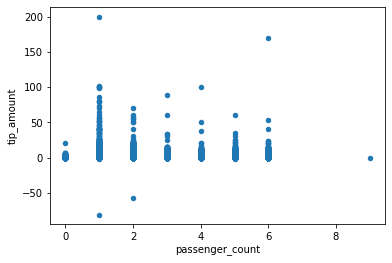

In [5]:
# does the number of riders influence the tip amount?
df.plot(kind='scatter', 
        x='passenger_count', 
        y='tip_amount')

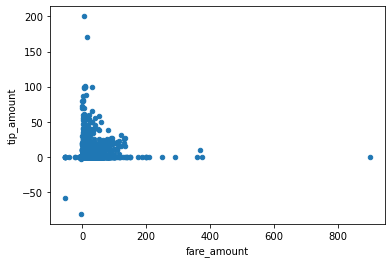

In [6]:
# does the fare amount influence the tip amount?
df.plot(kind='scatter', 
        x='fare_amount',
        y='tip_amount')

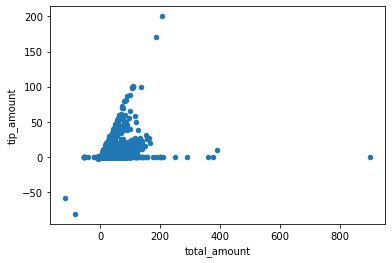

In [7]:
# does the total amount influence the tip amount?
df.plot(kind='scatter', 
        x='total_amount',
        y='tip_amount')

In [8]:
# pull averages & sums for passenger count, fare amount, tip amount, and trip distance by hour
by_hour = '''
          select
              hour(pickup_ts) as hours,
              sum(passenger_count),
              avg(passenger_count),
              sum(fare_amount),
              avg(fare_amount),
              sum(tip_amount),
              avg(tip_amount),
              sum(trip_distance),
              avg(trip_distance)
          from 
              (
              select
                  *,
                  cast(tpep_pickup_datetime || '.0' as TIMESTAMP) as pickup_ts,
                  cast(tpep_pickup_datetime || '.0' as TIMESTAMP) as dropoff_ts
              from 
                  taxi
                  )
          group by
              hour(pickup_ts)
          order by
              hour(pickup_ts)
              '''
# convert to pandas and plot a correlation matrix
bc.sql(by_hour).to_pandas().corr().style.background_gradient(cmap='coolwarm')

,hours,sum(passenger_count),avg($1),sum(fare_amount),avg($2),sum(tip_amount),avg($3),sum(trip_distance),avg($4)
hours,1,0.785937,-0.0102557,0.778064,-0.523086,0.803026,0.15769,0.525038,-0.483771
sum(passenger_count),0.785937,1,-0.00558148,0.997154,-0.713168,0.988004,0.0440069,0.772153,-0.48472
avg($1),-0.0102557,-0.00558148,1,-0.0281265,0.496934,-0.0199327,0.337525,-0.135092,-0.00707797
sum(fare_amount),0.778064,0.997154,-0.0281265,1,-0.699244,0.98952,0.062789,0.793039,-0.460508
avg($2),-0.523086,-0.713168,0.496934,-0.699244,1,-0.682724,0.356019,-0.521558,0.498658
sum(tip_amount),0.803026,0.988004,-0.0199327,0.98952,-0.682724,1,0.177186,0.801167,-0.427332
avg($3),0.15769,0.0440069,0.337525,0.062789,0.356019,0.177186,1,0.218678,0.335994
sum(trip_distance),0.525038,0.772153,-0.135092,0.793039,-0.521558,0.801167,0.218678,1,0.147044
avg($4),-0.483771,-0.48472,-0.00707797,-0.460508,0.498658,-0.427332,0.335994,0.147044,1


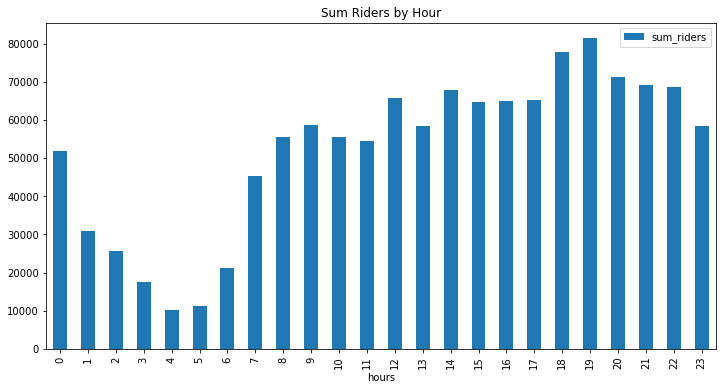

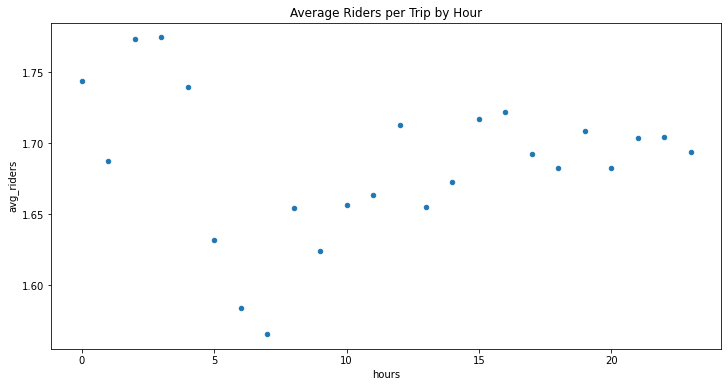

In [9]:
riders_by_hour = '''
                 select
                     hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP)) as hours,
                     sum(passenger_count) as sum_riders
                 from
                     taxi
                 group by
                     hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP))
                 order by
                     hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP))
                     '''
# utilize matplotlib to display sum riders by hour
bc.sql(riders_by_hour).to_pandas().plot(kind='bar', x='hours', y='sum_riders', title='Sum Riders by Hour', figsize=(12, 6))

riders_by_hour = '''
                 select
                     hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP)) as hours,
                     avg(passenger_count) as avg_riders
                 from
                     taxi
                 group by
                     hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP))
                     '''
# utilize matplotlib to display average riders by hour
bc.sql(riders_by_hour).to_pandas().plot(kind='scatter', x='hours', y='avg_riders', title='Average Riders per Trip by Hour', figsize=(12, 6))

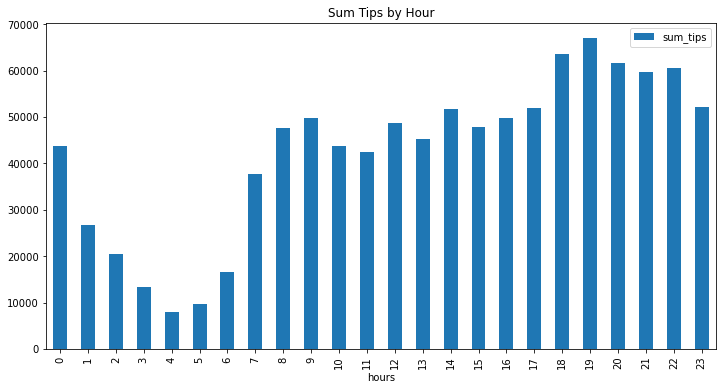

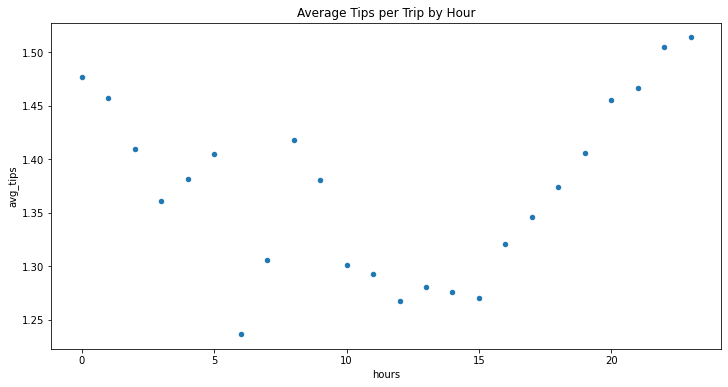

In [10]:
tips_by_hour = '''
               select
                   hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP)) as hours,
                   sum(tip_amount) as sum_tips
               from
                   taxi
               group by
                   hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP))
                 order by
                     hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP))
                     '''
# utilize matplotlib to display sum tips by hour
bc.sql(tips_by_hour).to_pandas().plot(kind='bar', x='hours', y='sum_tips', title='Sum Tips by Hour', figsize=(12, 6))

tips_by_hour = '''
               select
                   hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP)) as hours,
                   avg(tip_amount) as avg_tips
               from
                   taxi
               group by
                   hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP))
                   '''
# utilize matplotlib to display sum tips by hour
bc.sql(tips_by_hour).to_pandas().plot(kind='scatter', x='hours', y='avg_tips', title='Average Tips per Trip by Hour', figsize=(12, 6))

### Datashader
    
[GitHub](https://github.com/holoviz/datashader/)

Datashader is a data rasterization pipeline for automating the process of creating meaningful representations of large amounts of data.

Datashader breaks the creation of images of data into 3 main steps:

1. Projection
  - Each record is projected into zero or more bins of a nominal plotting grid shape, based on a specified glyph.
2. Aggregation
  - Reductions are computed for each bin, compressing the potentially large dataset into a much smaller aggregate array.
3. Transformation
  - These aggregates are then further processed, eventually creating an image.

Using this very general pipeline, many interesting data visualizations can be created in a performant and scalable way. Datashader contains tools for easily creating these pipelines in a composable manner, using only a few lines of code. Datashader can be used on its own, but it is also designed to work as a pre-processing stage in a plotting library, allowing that library to work with much larger datasets than it would otherwise.

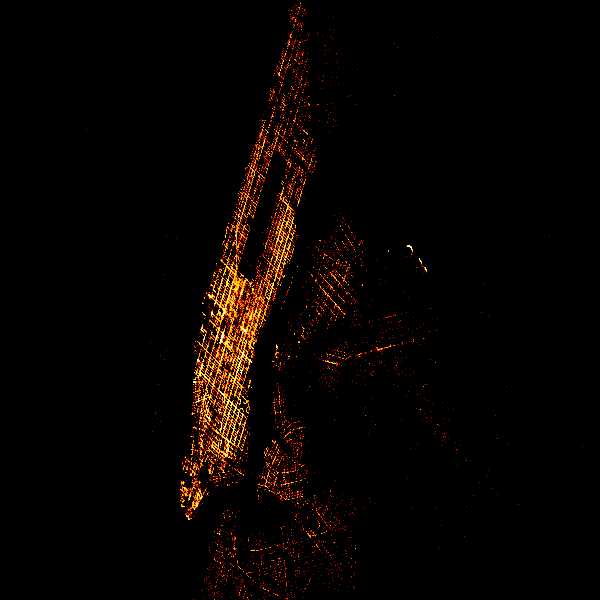

In [11]:
from datashader import Canvas, transfer_functions
from colorcet import fire

# find the dropoff coordinates of all rides from midnight to 5am
query = '''
        select 
            dropoff_x, 
            dropoff_y 
        from 
            taxi 
            where  
                hour(cast(tpep_pickup_datetime || '.0' as TIMESTAMP)) BETWEEN 0 AND 5
                '''
# execute query & lay out a canvas w/ dropoff locations 
nyc = Canvas().points(bc.sql(query), 'dropoff_x', 'dropoff_y')

# shade in the picture w/ fire & display
transfer_functions.set_background(transfer_functions.shade(nyc, cmap=fire), "black")

### HoloViews 

[GitHub](https://github.com/holoviz/holoviews)

HoloViews is an open-source Python library designed to make data analysis and visualization seamless and simple. With HoloViews, you can usually express what you want to do in very few lines of code, letting you focus on what you are trying to explore and convey, not on the process of plotting.

By calling the `.to_pandas()` method, we can convert a `cudf.DataFrame` into a `pandas.DataFrame` and hand off to HoloViews or other CPU visualization packages.

In [12]:
from holoviews import extension
from holoviews.element.tiles import EsriImagery

# config holoviews extension
extension('bokeh')

ModuleNotFoundError: No module named 'holoviews'

In [ ]:
from holoviews import opts
opts.defaults(opts.Scatter(width=450, height=450, color='blue'), opts.RGB(width=450, height=450), opts.Curve(width=450))

from holoviews import Scatter
import holoviews.operation.datashader as hd

# compare trip distance with tip amount 
s = Scatter(bc.sql('select trip_distance, tip_amount from taxi').to_pandas(), 'trip_distance', 'tip_amount')

# set scope range from 0 miles - 25 miles and $0 - $50
ranged = s.redim.range(trip_distance=(0, 25), tip_amount=(0, 50))

shaded = hd.spread(hd.datashade(ranged))

shaded.redim.label(trip_distance="Trip Distance", tip_amount="Tip ($)")

## That's the Data Vizualization Tour!

You've seen the basics of Data Visualization in BlazingSQL Notebooks and how to utilize it. Now is a good time to experiment with your own data and see how to parse, clean, and extract meaningful insights from it.

We'll now get into how to run Machine Learning with popular Python and GPU-accelerated Python packages.


[Continue to the Machine Learning introductory Notebook](machine_learning.ipynb)